In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location

In [2]:
# !pip install cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

In [3]:
results_folder = 'cell2location/results/lymph_nodes_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

[03/08/25 14:41:40] WARNING  /tmp/ipykernel_3139715/520053249.py:1: FutureWarning: Use              ]8;id=731484;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=238906;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             `squidpy.datasets.visium` instead.                                                    
                               adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")                 
                                                                                                                   

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=92540;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=337438;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/scanpy/datasets/_datasets.py:558:                  
                             FutureWarning: Use `squidpy.read.visium` instead.                                     
                               return read_visium(sample_dir, source_image_path=source_image_path)                 
                                                                                                                   

[03/08/25 14:41:41] WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=903262;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=313976;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758:                     
                             UserWarning: Variable names are not unique. To make them unique, call                 
                             `.var_names_make_unique`.                                                             
                               utils.warn_names_duplicates("var")                                                  
                                                                                                                   

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=868309;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=132631;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758:                     
                             UserWarning: Variable names are not unique. To make them unique, call                 
                             `.var_names_make_unique`.                                                             
                               utils.warn_names_duplicates("var")                                                  
                                                                                                                   

In [5]:
# Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data - so you can ignore the 
#scanpy suggestion to call .var_names_make_unique.
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

[03/08/25 14:41:46] WARNING  /tmp/ipykernel_3139715/1220694083.py:1: FutureWarning: Use             ]8;id=498721;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=432328;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             `squidpy.pl.spatial_scatter` instead.                                                 
                               sc.pl.spatial(adata_vis, color='PTPRC', gene_symbols='SYMBOL')                      
                                                                                                                   

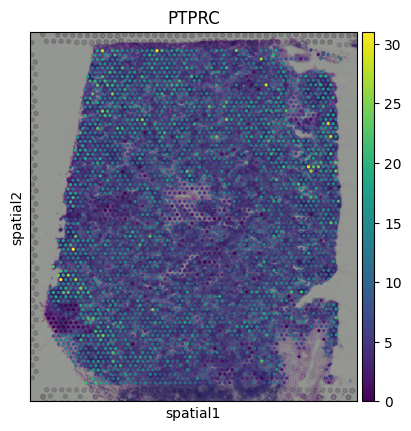

In [6]:
sc.pl.spatial(adata_vis, color='PTPRC', gene_symbols='SYMBOL')

Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.

In [7]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

Published scRNA-seq datasets of lymph nodes have typically lacked an adequate representation of germinal centre-associated immune cell populations due to age of patient donors. We, therefore, include scRNA-seq datasets spanning lymph nodes, spleen and tonsils in our single-cell reference to ensure that we captured the full diversity of immune cell states likely to exist in the spatial transcriptomic dataset.

Here we download this dataset, import into anndata and change variable names to ENSEMBL gene identifiers.

In [8]:
# Read data
adata_ref = sc.read(
    f'./data/sc.h5ad',
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)

Note!

Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

The default parameters cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12 are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low cell_count_cutoff=5, however, cell_percentage_cutoff2 and nonz_mean_cutoff can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In this case, the downloaded dataset was already filtered using this method, hence no density under the orange rectangle (to be changed in the future version of the tutorial).

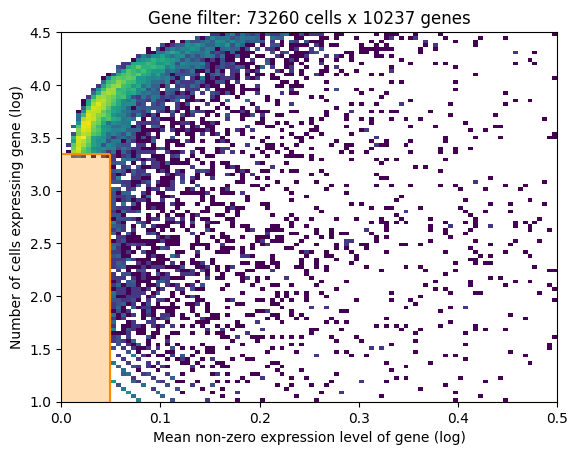

In [9]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

Estimation of reference cell type signatures (NB regression)
The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

Preparing anndata.

First, prepare anndata object for the regression model:

In [10]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
    # 10X reaction / sample / batch
    batch_key='Sample',
    # cell type, covariate used for constructing signatures
    labels_key='Subset',
    # multiplicative technical effects (platform, 3' vs 5', donor effect)
    categorical_covariate_keys=['Method']
   )

In [11]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  23   │
│         n_cells          │ 73260 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 10237 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    4861STDY7135913     │          0          │
│                     │    4861STDY7135914     │          1          │
│                     │    4861STDY7208412     │          2          │
│                     │    4861STDY7208413     │          3          │
│                     │    4861STDY7462253     │          4          │
│                     │    4861STDY7462254     │          5          │
│                     │    4861STDY7462255     │          6          │
│                     │    4861STDY7462256     │          7          │
│                     │    4861STDY7528597     │          8          │
│                     │    4861STDY7528598     │          9          │
│                     │    4861STDY7528599     │         10          │
│                     │    4861STDY7528600     │         11          │
│                     │      BCP002_Total      │         12          │
│                     │      BCP003_Total      │         13          │
│                     │      BCP004_Total      │         14          │
│                     │      BCP005_Total      │         15          │
│                     │      BCP006_Total      │         16          │
│                     │      BCP008_Total      │         17          │
│                     │      BCP009_Total      │         18          │
│                     │ Human_colon_16S7255677 │         19          │
│                     │ Human_colon_16S7255678 │         20          │
│                     │ Human_colon_16S8000484 │         21          │
│                     │      Pan_T7935494      │         22          │
└─────────────────────┴────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

Training model.

Now we train the model to estimate the reference cell type signatures.

Note that to achieve convergence on your data (=to get stabilization of the loss) you may need to increase max_epochs=250 (See below).

Also note that here we are using batch_size=2500 which is much larger than scvi-tools default and perform training on all cells in the data (train_size=1) - both parameters are defaults.

In [12]:
# mod.train(max_epochs=250)

[03/08/25 13:56:58] WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=42936;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=94108;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/torch/cuda/__init__.py:734:                        
                             UserWarning: Can't initialize NVML                                                    
                               warnings.warn("Can't initialize NVML")                                              
                                                                                                                   

INFO: GPU available: True (cuda), used: True


                    INFO     GPU available: True (cuda), used: True                                 ]8;id=880786;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=177393;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


                    INFO     TPU available: False, using: 0 TPU cores                               ]8;id=165576;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=470908;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


                    INFO     HPU available: False, using: 0 HPUs                                    ]8;id=470148;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=558488;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=215736;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=119643;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/trainer/configura                
                             tion_validator.py:68: You passed in a `val_dataloader` but have no                    
                             `validation_step`. Skipping val loop.                                                 
                                                                                                                   

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=434302;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=965474;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/torch/cuda/__init__.py:734:                        
                             UserWarning: Can't initialize NVML                                                    
                               warnings.warn("Can't initialize NVML")                                              
                                                                                                                   

INFO: You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


                    INFO     You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor       ]8;id=430257;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=138155;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             Cores. To properly utilize them, you should set                                       
                             `torch.set_float32_matmul_precision('medium' | 'high')` which will                    
                             trade-off precision for performance. For more details, read                           
                             https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_pre                
                             cision.html#torch.set_float32_matmul_precision                                        

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=826365;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=203065;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=440897;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=191425;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connector                
                             s/data_connector.py:425: The 'train_dataloader' does not have many                    
                             workers which may be a bottleneck. Consider increasing the value of                   
                             the `num_workers` argument` to `num_workers=31` in the `DataLoader` to                
                             improve performance.                                                                  
                                                                                                                   

Training:   0%|          | 0/250 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=250` reached.


[03/08/25 14:15:10] INFO     `Trainer.fit` stopped: `max_epochs=250` reached.                       ]8;id=962834;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=502658;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

Determine if the model needs more training.

Here, we plot ELBO loss history during training, removing first 20 epochs from the plot. This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, increase max_epochs.

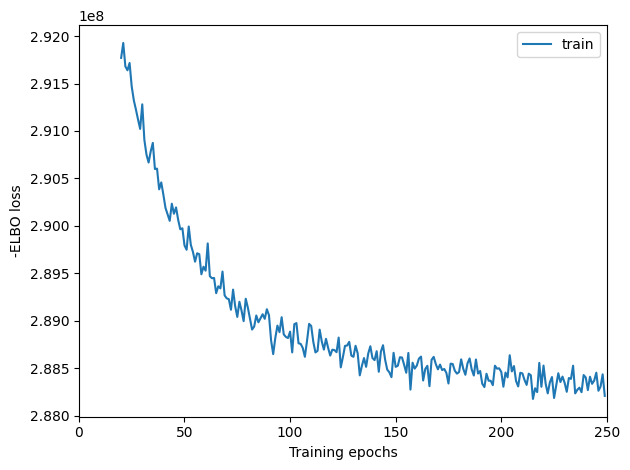

In [13]:
mod.plot_history(20)

### Baixar os dados da Mariana, fazer o filtro

Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

### Treinar o modelo com cell2celllocation

In [18]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling local variables, batch:   0%|          | 0/30 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

'cell2location/results/lymph_nodes_analysis//reference_signatures/sc.h5ad'

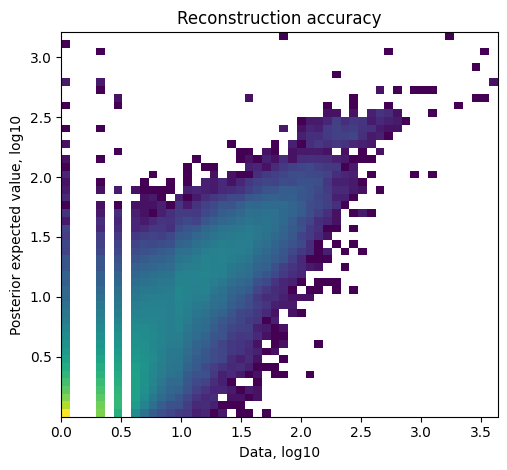

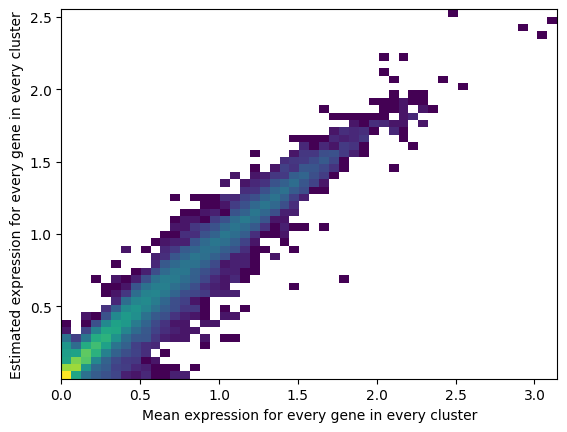

In [20]:
mod.plot_QC()

In [10]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

[03/08/25 14:43:05] WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=444679;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=373896;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/torch/cuda/__init__.py:734:                        
                             UserWarning: Can't initialize NVML                                                    
                               warnings.warn("Can't initialize NVML")                                              
                                                                                                                   

INFO     File cell2location/results/lymph_nodes_analysis//reference_signatures/model.pt already downloaded         


INFO: GPU available: True (cuda), used: True


[03/08/25 14:43:06] INFO     GPU available: True (cuda), used: True                                 ]8;id=483629;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=625468;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


                    INFO     TPU available: False, using: 0 TPU cores                               ]8;id=791863;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=66620;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


                    INFO     HPU available: False, using: 0 HPUs                                    ]8;id=788904;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=576933;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=387255;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=389381;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/trainer/configura                
                             tion_validator.py:68: You passed in a `val_dataloader` but have no                    
                             `validation_step`. Skipping val loop.                                                 
                                                                                                                   

INFO: You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


                    INFO     You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor       ]8;id=190483;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=215099;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
                             Cores. To properly utilize them, you should set                                       
                             `torch.set_float32_matmul_precision('medium' | 'high')` which will                    
                             trade-off precision for performance. For more details, read                           
                             https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_pre                
                             cision.html#torch.set_float32_matmul_precision                                        

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=583748;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=956433;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=514982;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=734240;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connector                
                             s/data_connector.py:425: The 'train_dataloader' does not have many                    
                             workers which may be a bottleneck. Consider increasing the value of                   
                             the `num_workers` argument` to `num_workers=31` in the `DataLoader` to                
                             improve performance.                                                                  
                                                                                                                   

Training:   0%|          | 0/273 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1` reached.


[03/08/25 14:43:08] INFO     `Trainer.fit` stopped: `max_steps=1` reached.                          ]8;id=619457;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=887981;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

In [11]:
mod

RegressionBackgroundDetectionTech model with the following params: 
n_factors: 34 
n_batch: 23 
Training status: Trained
<class 'cell2location.models.reference._reference_model.RegressionModel'>.__repr__ returned empty string

In [12]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN
NOC2L,0.431292,0.244131,0.310114,0.354068,0.154735
HES4,0.002196,0.000686,0.000733,0.058215,0.043580
ISG15,0.386321,0.211898,0.275643,0.503765,3.929418
TNFRSF18,0.020364,0.000794,0.055562,0.070635,0.009503
TNFRSF4,0.007872,0.000619,0.006342,0.029030,0.011407


In [13]:
inf_aver

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN,B_activated,B_mem,B_naive,B_plasma,B_preGC,...,T_CD4+_TfH,T_CD4+_TfH_GC,T_CD4+_naive,T_CD8+_CD161+,T_CD8+_cytotoxic,T_CD8+_naive,T_TIM3+,T_TfR,T_Treg,VSMC
NOC2L,0.431292,0.244131,0.310114,0.354068,0.154735,0.174802,0.184384,0.155241,0.259309,0.381816,...,0.132197,0.158773,0.194465,0.129089,0.120407,0.237990,0.348438,0.190213,0.161000,0.220094
HES4,0.002196,0.000686,0.000733,0.058215,0.043580,0.011586,0.034018,0.006996,0.001390,0.019611,...,0.047810,0.037433,0.069367,0.016469,0.004520,0.022249,0.189952,0.365477,0.064431,1.506824
ISG15,0.386321,0.211898,0.275643,0.503765,3.929418,0.132914,0.259154,0.130702,0.345195,0.119761,...,0.220611,0.409171,0.346827,0.289743,0.312293,0.446378,1.845451,0.625220,0.329420,0.363892
TNFRSF18,0.020364,0.000794,0.055562,0.070635,0.009503,0.004127,0.003552,0.000376,0.153421,0.148023,...,0.015316,0.350153,0.001810,0.060625,0.013485,0.000863,0.343048,1.055089,0.438980,0.041226
TNFRSF4,0.007872,0.000619,0.006342,0.029030,0.011407,0.001121,0.004032,0.000394,0.088241,0.055463,...,0.140749,0.696508,0.035984,0.068235,0.014734,0.001736,0.555482,1.927956,0.864254,0.041975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGL_VDJsum,9.760017,7.449984,3.715995,10.539213,4.147597,2.990207,3.072323,2.801951,299.467834,3.874713,...,0.025961,0.028878,0.062903,0.044239,0.060168,0.050337,0.200964,0.057203,0.029121,0.051247
TCRA_VDJsum,0.024572,0.003146,0.009854,0.042816,0.003041,0.002048,0.001971,0.000298,0.045822,0.002898,...,1.833526,1.792528,1.771214,1.626395,1.454190,1.612475,2.833008,2.115476,2.393921,0.201594
TCRB_VDJsum,0.045498,0.001799,0.006699,0.007553,0.005920,0.003588,0.006627,0.004009,0.085637,0.001766,...,2.700967,4.576511,2.608066,1.841288,2.221194,2.260228,5.180290,5.150938,3.280547,0.100723
TCRD_VDJsum,0.000619,0.002068,0.002306,0.266382,0.025137,0.000510,0.000293,0.000242,0.002204,0.004861,...,0.023388,0.020275,0.023349,0.129305,0.069283,0.045821,0.072708,0.020367,0.022496,0.484493


Important
To use cell2location spatial mapping model, you need to specify 2 user-provided hyperparameters (N_cells_per_location and detection_alpha) - for detailed guidance on setting these hyperparameters and their impact see the flow diagram and the note.

In [14]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [17]:
# create and train the model
mod_c2l = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod_c2l.view_anndata_setup()

[03/08/25 14:52:20] WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=800376;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=238951;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/cell2location/models/_cell2location                
                             _model.py:91: RuntimeWarning: invalid value encountered in scalar                     
                             divide                                                                                
                               self.detection_mean_ = (sp_total /                                                  
                             model_kwargs.get("N_cells_per_location", 1)) / sc_total                               
                                                                                                                   

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4035  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V1_Human_Lymph_Node │          0          │
└─────────────────────┴─────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [20]:
mod_c2l.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         )

INFO: GPU available: True (cuda), used: True


[03/08/25 14:55:36] INFO     GPU available: True (cuda), used: True                                 ]8;id=126476;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=164485;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


                    INFO     TPU available: False, using: 0 TPU cores                               ]8;id=958646;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=387916;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


                    INFO     HPU available: False, using: 0 HPUs                                    ]8;id=857153;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=723660;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=566193;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=640863;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/trainer/configura                
                             tion_validator.py:68: You passed in a `val_dataloader` but have no                    
                             `validation_step`. Skipping val loop.                                                 
                                                                                                                   

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=884139;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=515264;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=339798;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=635272;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connector                
                             s/data_connector.py:425: The 'train_dataloader' does not have many                    
                             workers which may be a bottleneck. Consider increasing the value of                   
                             the `num_workers` argument` to `num_workers=31` in the `DataLoader` to                
                             improve performance.                                                                  
                                                                                                                   

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=20099;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=730579;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py                
                             :310: The number of training batches (1) is smaller than the logging                  
                             interval Trainer(log_every_n_steps=10). Set a lower value for                         
                             log_every_n_steps if you want to see logs for the training epoch.                     
                                                                                                                   

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site- │
│ packages/pyro/poutine/trace_messenger.py:191 in __call__                                         │
│                                                                                                  │
│   188 │   │   │   │   "_INPUT", name="_INPUT", type="args", args=args, kwargs=kwargs             │
│   189 │   │   │   )                                                                              │
│   190 │   │   │   try:                                                                           │
│ ❱ 191 │   │   │   │   ret = self.fn(*args, **kwargs)                                             │
│   192 │   │   │   except (ValueError, RuntimeError) as e:                                        │
│   193 │   │   │   │   exc_type, exc_value, traceback = sys.exc_info()                            │
│   194 │   │   │   │   shapes = self.msngr.trace.format_shapes()                                  │
│                                                                                                  │
│ /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site- │
│ packages/pyro/poutine/messenger.py:32 in _context_wrap                                           │
│                                                                                                  │
│    29 │   **kwargs: Any,                                                                         │
│    30 ) -> Any:                                                                                  │
│    31 │   with context:                                                                          │
│ ❱  32 │   │   return fn(*args, **kwargs)                                                         │
│    33                                                                                            │
│    34                                                                                            │
│    35 class _bound_partial(partial):                                                             │
│                                                                                                  │
│ /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site- │
│ packages/pyro/poutine/messenger.py:32 in _context_wrap                                           │
│                                                                                                  │
│    29 │   **kwargs: Any,                                                                         │
│    30 ) -> Any:                                                                                  │
│    31 │   with context:                                                                          │
│ ❱  32 │   │   return fn(*args, **kwargs)                                                         │
│    33                                                                                            │
│    34                                                                                            │
│    35 class _bound_partial(partial):                                                             │
│                                                                                                  │
│ /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site- │
│ packages/pyro/nn/module.py:520 in __call__                                                       │
│                                                                                                  │
│   517 │                                                                                          │
│   518 │   def __call__(self, *args: Any, **kwargs: Any) -> Any:                                  │
│   519 │   │   with self._pyro_context:                     